Imports

In [113]:
import warnings
import numpy as np
import pandas as pd
import xgboost as xgb
import tensorflow as tf
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.externals import joblib 
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from tensorflow.keras.layers import Dense, Dropout, LSTM
from statsmodels.stats.outliers_influence import variance_inflation_factor
from tensorflow.keras.layers import Conv1D, Conv2D, Activation,MaxPooling1D, MaxPooling2D, Flatten, AveragePooling1D
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

# **Sentiment Analysis on Elon Musk News Articles**

In [114]:
#!pip install vaderSentiment

In [115]:
import re
import string
import calendar
import requests
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [116]:
sentiment_Analysis = 0

In [117]:
df = pd.read_csv('/content/drive/MyDrive/dataset/stock_prices.csv')

In [118]:
df

,Date,Open,High,Low,Close,Volume
0,2013-01-02,7.000000,7.090000,6.942000,7.072000,5974000
1,2013-01-03,7.036000,7.090000,6.950000,6.954000,3710000
2,2013-01-04,6.960000,6.960000,6.784000,6.880000,3370000
3,2013-01-07,6.960000,6.960000,6.780000,6.868000,2210000
4,2013-01-08,6.900000,6.900000,6.622000,6.736000,6420000
...,...,...,...,...,...,...
2133,2021-06-23,632.000000,657.200012,630.039978,656.570007,31099200
2134,2021-06-24,674.989990,697.619995,667.609985,679.820007,45982400
2135,2021-06-25,689.580017,693.809998,668.700012,671.869995,32496700
2136,2021-06-28,671.640015,694.700012,670.320007,688.719971,21628200


Get the news article links for 325 pages

In [119]:
def getLinks():
    pages = 325
    searchText = "Elon+Musk"
    links = []

    for i in range(1, pages):
        if i == 1:
          url = "https://financialpost.com/search/?search_text={0}&date_range=-3650d&sort=asc".format(searchText)
        else:
          url = "https://financialpost.com/search/?search_text={0}&date_range=-3650d&sort=asc&from={1}".format(searchText, str((i-1)*10))
        
        contents = BeautifulSoup(requests.get(url).content, "html.parser")
        srcData = contents.select("a.article-card__link")
        
        links = links + ["https://financialpost.com"+str(row['href']) for row in srcData]
      
    links_df = pd.DataFrame(links)
    links_df.to_csv("/content/drive/MyDrive/dataset/Links.csv")

Get the news article and create dataframe

In [120]:
def getNewsarticles():
    df_text = pd.DataFrame(columns=['Date', 'URL', 'Full_Text'])
    for i in range(0, len(links)):
      print(i)
      url = links_df[0][i]
      contentsData = BeautifulSoup(requests.get(url).content, "html.parser")
      try:
          data = contentsData.find("article",class_ = "article-content-story article-content-story--story").find_all("p")
      except:
          data = contentsData.find("article",class_ = "article-content-story article-content-story--story").find("p")
      text = [p.text for p in data]
      try:
          dateList = re.sub(r'[-,:;]', '', contentsData.find("span",class_ = "published-date__since").text).split(' ')
      except:
          dateList = re.sub(r'[-,:;]', '', contentsData.find_all("span",class_ = "published-date__since").text).split(' ')

      month_num = list(calendar.month_abbr).index(dateList[0])
      date = dateList[1]
      if len(str(date))==1:
        date = '0'+ str(date)
      if len(str(month_num))==1:
        month_num = '0' + str(month_num)
      art_Date = '{0}-{1}-{2}'.format(dateList[2], month_num, date)

      df_text = df_text.append({'Date': art_Date, 'URL': url, 'Full_Text': text}, ignore_index=True)

    df_text.to_csv("/content/drive/MyDrive/dataset/ArticleText.csv")

Polarity analysis of News article

In [121]:
def polarityanalysis():
    single = []
    paragraph = []
    handler = SentimentIntensityAnalyzer()

    df_text = pd.read_csv('/content/drive/MyDrive/dataset/ArticleText.csv')

    for i in range(0, len(df_text)):
      tempText = re.sub(r"[\',]", '', df_text['Full_Text'][i])
      sentText = re.split('(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s',tempText)
      sentText = sentText[:len(sentText)-10]
      temp_Single = []
      
      for j in sentText:
        temp_Single.append(handler.polarity_scores(j)['compound'])   

      single.append(np.mean(temp_Single))
      paragraph.append(handler.polarity_scores(sentText)['compound'])

    df_text['Single_Line'] = single
    df_text['Whole_Paragraph'] = paragraph

    df_text.drop(columns=['URL', 'Full_Text', 'Unnamed: 0'])

    aggregation_functions = {'Single_Line': 'mean', 'Whole_Paragraph': 'mean'}
    df_text = df_text.groupby(df_text['Date']).aggregate(aggregation_functions)

    df_merge = pd.merge(df, df_text, on=['Date'], how='left')
    df_merge = df_merge.fillna(0)

    df_merge.to_csv("/content/drive/MyDrive/dataset/merged_df.csv")

In [122]:
if sentiment_Analysis == 1:
    getLinks()
    getNewsarticles()
    polarityanalysis()

# **Model1- LSTM**

In [123]:
df = pd.read_csv('/content/drive/MyDrive/dataset/merged_df.csv')

In [124]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [125]:
df = df.drop(df.loc[:, ~df.columns.isin(['Volume', 'Close', 'Single_Line'])].columns, axis = 1)

Check Multi Colinearity of features

In [126]:
vif = pd.DataFrame()
vif["variables"] = df.columns
vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
vif

,variables,VIF
0,Close,1.484850
1,Volume,1.428596
2,Single_Line,1.423371


Split Dataset

In [127]:
sample, test = train_test_split(df, test_size=0.005, shuffle = False)
train, val = train_test_split(sample, train_size = 0.8, shuffle = False)

Scaling Data

In [128]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data_train = scaler.fit_transform(train)
scaled_data_validate = scaler.fit_transform(val)
val_Test = np.concatenate((val, test))
scaled_data_validate_test = scaler.fit_transform(val_Test)

In [129]:
timeStep = 50
train_X, train_Y = [], []
val_X, val_Y = [], []

for i in range(timeStep, len(scaled_data_train)):
  train_X.append(scaled_data_train[i-timeStep:i,:])
  train_Y.append([scaled_data_train[i, 0]])

for i in range(timeStep, len(scaled_data_validate)):   
  val_X.append(scaled_data_validate[i-timeStep:i,:])
  val_Y.append([scaled_data_validate[i, 0]])

train_X, train_Y = np.array(train_X), np.array(train_Y)
val_X, val_Y = np.array(val_X), np.array(val_Y)

Model Creation

In [ ]:
model1 = Sequential()
model1.add(LSTM(50,  return_sequences=False, input_shape=(train_X.shape[1], train_X.shape[2])))
model1.add(Dense(1))
model1.compile(optimizer='Adam', loss='mean_squared_error')

In [ ]:
model1.fit(train_X, train_Y, epochs=50, batch_size=50, verbose=1)

Epoch 1/50
34/34 [==============================] - 2s 23ms/step - loss: 0.0011
Epoch 2/50
34/34 [==============================] - 1s 22ms/step - loss: 0.0011
Epoch 3/50
34/34 [==============================] - 1s 21ms/step - loss: 0.0010
Epoch 4/50
34/34 [==============================] - 1s 22ms/step - loss: 0.0010
Epoch 5/50
34/34 [==============================] - 1s 22ms/step - loss: 0.0010
Epoch 6/50
34/34 [==============================] - 1s 22ms/step - loss: 0.0010
Epoch 7/50
34/34 [==============================] - 1s 22ms/step - loss: 9.8619e-04
Epoch 8/50
34/34 [==============================] - 1s 22ms/step - loss: 9.8092e-04
Epoch 9/50
34/34 [==============================] - 1s 22ms/step - loss: 9.7236e-04
Epoch 10/50
34/34 [==============================] - 1s 22ms/step - loss: 9.5683e-04
Epoch 11/50
34/34 [==============================] - 1s 21ms/step - loss: 0.0010
Epoch 12/50
34/34 [==============================] - 1s 22ms/step - loss: 9.5313e-04
Epoch 13/50
34/34

In [132]:
model1.save('LSTM_model1_multivariate.h5')

In [133]:
prediction_Val_Y = model1.predict(val_X) 

In [134]:
predict = np.repeat(prediction_Val_Y, train.shape[1], axis=-1)
prediction_Val = scaler.inverse_transform(predict)[:, 0]

In [135]:
val_Y_repeated = np.repeat(val_Y, train.shape[1], axis=-1)
val_Y = scaler.inverse_transform(val_Y_repeated)[:, 0]

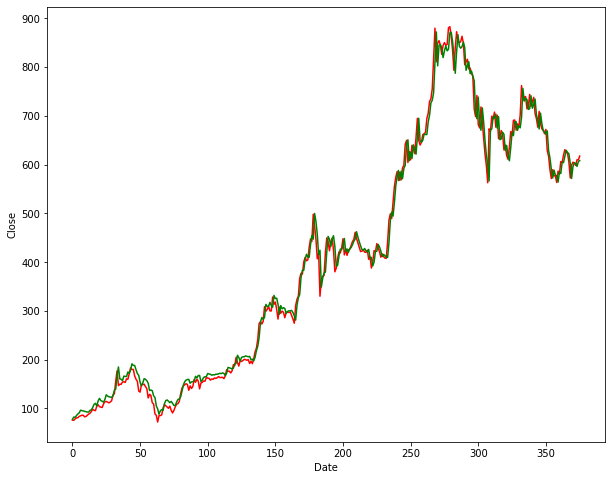

In [136]:
plt.figure(figsize=(10,8))
plt.xlabel('Date')
plt.ylabel('Close')
plt.plot(val_Y, color = 'red', linewidth =1.5)
plt.plot(prediction_Val, color = 'green', linewidth = 1.5)

Future Forecast

In [137]:
x_input = val_X
lst_output=[]
n_steps=50
i=0
while(i<11):
    
    if(i >= 1):
        x_input_last = x_input[-1]
        x_input_add = scaled_data_validate_test[(426+i):(427+i)]
        x_input_add[0][0] = yhat[-1][0]     
        x_input_last = np.concatenate((x_input_last,x_input_add))
        x_input = np.concatenate((x_input, np.reshape(x_input_last[1:], (1,n_steps,3))))
        yhat = model1.predict(x_input, verbose=0)
        i=i+1
    else:
        x_input_last = x_input[-1]
        x_input_add = scaled_data_validate_test[(426+i):(427+i)]
        x_input_add[0][0] = prediction_Val_Y[-1][0]
        x_input_last = np.concatenate((x_input_last,x_input_add))
        x_input = np.concatenate((x_input, np.reshape(x_input_last[1:], (1,n_steps,3))))
        yhat = model1.predict(x_input, verbose=0)
        i=i+1

In [138]:
predict_test = np.repeat(yhat, train.shape[1], axis=-1)
prediction_test = scaler.inverse_transform(predict_test)[:, 0]
prediction_test = prediction_test[376:]

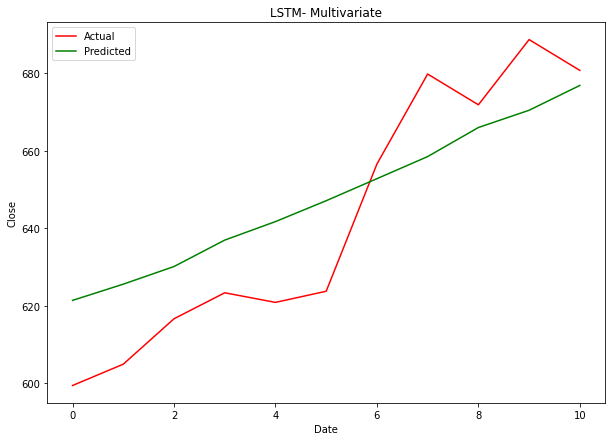

In [ ]:
plt.figure(figsize=(10,7))
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('LSTM- Multivariate')
plt.plot(test['Close'].values, color = 'red', linewidth =1.5, label = 'Actual')
plt.plot(prediction_test, color = 'green', linewidth = 1.5, label = 'Predicted')
plt.legend()

In [ ]:
#rmse value on the test data
result = mean_squared_error(test['Close'].values,prediction_test, squared=False)
print(result)

16.821745412037682


In [ ]:
prediction_test

array([621.35004, 625.5395 , 630.09625, 636.9221 , 641.70105, 647.0961 ,
       652.7879 , 658.49615, 666.003  , 670.46094, 676.8719 ],
      dtype=float32)

# **Model2- CNN**

In [162]:
df_cnn = pd.read_csv('/content/drive/MyDrive/dataset/merged_df.csv')

In [163]:
df_cnn['Date'] = pd.to_datetime(df_cnn['Date'])
df_cnn.set_index('Date', inplace=True)

In [164]:
df_cnn = df_cnn.drop(df_cnn.loc[:, ~df_cnn.columns.isin(['Volume', 'Close', 'Whole_Paragraph'])].columns, axis = 1)

Check Multicolinearity

In [165]:
vif = pd.DataFrame()
vif["variables"] = df_cnn.columns
vif["VIF"] = [variance_inflation_factor(df_cnn.values, i) for i in range(df_cnn.shape[1])]
vif

,variables,VIF
0,Close,1.452416
1,Volume,1.455157
2,Whole_Paragraph,1.417348


Split dataset

In [166]:
sample, test = train_test_split(df_cnn, test_size=0.005, shuffle = False)
train, val = train_test_split(sample, train_size = 0.80, shuffle = False)

Scaling features

In [167]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data_train = scaler.fit_transform(train)
scaled_data_validate = scaler.fit_transform(val)
val_Test = np.concatenate((val, test))
scaled_data_validate_test = scaler.fit_transform(val_Test)

Reshape dataset

In [168]:
timeStep = 50
train_X, train_Y = [], []
val_X, val_Y = [], []

for i in range(timeStep, len(scaled_data_train)):
  train_X.append(scaled_data_train[i-timeStep:i,:])
  train_Y.append([scaled_data_train[i, 0]])

for i in range(timeStep, len(scaled_data_validate)):   
  val_X.append(scaled_data_validate[i-timeStep:i,:])
  val_Y.append([scaled_data_validate[i, 0]])

train_X, train_Y = np.array(train_X), np.array(train_Y)
val_X, val_Y = np.array(val_X), np.array(val_Y)

Model Creation

In [ ]:
model2 = Sequential()
model2.add(LSTM(64, return_sequences=True, input_shape=(train_X.shape[1],3)))
model2.add(Conv1D(64, 3, padding='same', activation='relu'))
model2.add(LSTM(128, return_sequences=False))
model2.add(Dense(1)) 
model2.compile(loss='mean_squared_error', optimizer='Adam')

In [171]:
model2.fit(train_X, train_Y, epochs=100, batch_size=50, verbose=0)

In [172]:
prediction_Val_Y = model2.predict(val_X) 

Predict validation set

In [173]:
predict = np.repeat(prediction_Val_Y, train.shape[1], axis=-1)
prediction_Val = scaler.inverse_transform(predict)[:, 0]

In [174]:
val_Y_repeated = np.repeat(val_Y, train.shape[1], axis=-1)
val_Y = scaler.inverse_transform(val_Y_repeated)[:, 0]

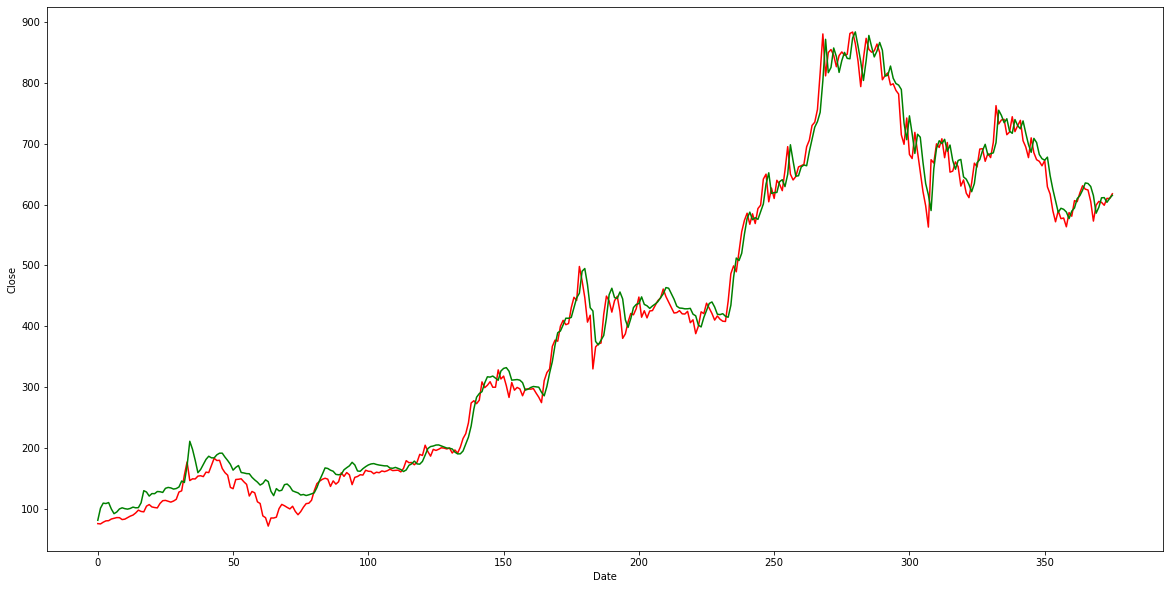

In [ ]:
plt.figure(figsize=(20,10))
plt.xlabel('Date')
plt.ylabel('Close')
plt.plot(val_Y, color = 'red', linewidth =1.5)
plt.plot(prediction_Val, color = 'green', linewidth = 1.5)

Future Forecast

In [176]:
x_input = val_X
lst_output=[]
n_steps=50
i=0
while(i<11):
    
    if(i >= 1):
        x_input_last = x_input[-1]
        x_input_add = scaled_data_validate_test[(426+i):(427+i)]
        x_input_add[0][0] = yhat[-1][0]     
        x_input_last = np.concatenate((x_input_last,x_input_add))
        x_input = np.concatenate((x_input, np.reshape(x_input_last[1:], (1,n_steps,3))))
        yhat = model2.predict(x_input, verbose=0)
        i=i+1
    else:
        x_input_last = x_input[-1]
        x_input_add = scaled_data_validate_test[(426+i):(427+i)]
        x_input_add[0][0] = prediction_Val_Y[-1][0]
        x_input_last = np.concatenate((x_input_last,x_input_add))
        x_input = np.concatenate((x_input, np.reshape(x_input_last[1:], (1,n_steps,3))))
        yhat = model2.predict(x_input, verbose=0)
        i=i+1

In [177]:
predict_test = np.repeat(yhat, train.shape[1], axis=-1)
prediction_test = scaler.inverse_transform(predict_test)[:, 0]
prediction_test = prediction_test[376:]

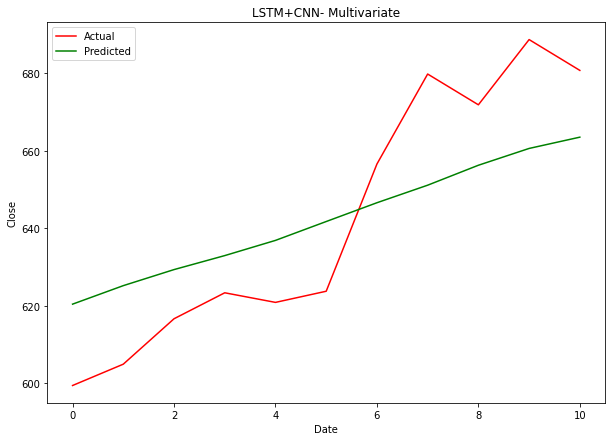

In [ ]:
plt.figure(figsize=(10,7))
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('LSTM+CNN- Multivariate')
plt.plot(test['Close'].values, color = 'red', linewidth =1.5, label='Actual')
plt.plot(prediction_test, color = 'green', linewidth = 1.5, label='Predicted')
plt.legend()

In [ ]:
#rmse value on the test data
result = mean_squared_error(test['Close'].values,prediction_test, squared=False)
print(result)

18.936289478194475


In [ ]:
prediction_test

array([620.3759 , 625.156  , 629.3031 , 632.9186 , 636.8448 , 641.7192 ,
       646.5712 , 651.104  , 656.25555, 660.59814, 663.512  ],
      dtype=float32)